In [1]:
#To Do:


In [2]:
import csv
import numpy as np
from collections import defaultdict
from matplotlib import pyplot
import pandas

In [3]:
BLANKS=["","RBNF1", "RBNF2", "RBNF", "0", "RBNF 1", "RBNF 2"]
#TOTAL= 5048
TOTAL=2734
#TOTAL=1351
#TOTAL=1201
#TOTAL=1168


In [4]:
def loadCsvData(fileName):
	matrix = []
	# open a file
	with open(fileName) as f:
		reader = csv.reader(f)
        # loop over each row in the file
		for row in reader:

			# cast each value to a float
			doubleRow = []
			for value in row:
				doubleRow.append(value.strip())

			# store the row into our matrix
			matrix.append(doubleRow)
	return matrix

In [5]:
def printData(matrix):
	for row in matrix:
		print (row)

In [6]:
data= loadCsvData("data/metadata.csv")

In [7]:
data=pandas.DataFrame(data[1:], columns=data[0])

In [8]:
interviewtxt =loadCsvData("data/interview text fille to ids.csv")

In [9]:
interviewtxt=pandas.DataFrame(interviewtxt[1:], columns=interviewtxt[0])


In [10]:
text_to_ids=defaultdict(lambda: defaultdict(lambda:"0"))
for i in range(len(interviewtxt)):
    if interviewtxt["no_transcript"][i]=="TRUE":
        continue
    name=interviewtxt.at[i, interviewtxt.columns[0]]
    name=name[:name.rfind('.')]
    name=name.replace('\'','_')
    text_to_ids[name]["id"]=interviewtxt["interviewee_ids"][i].split(';')
    date=interviewtxt["date_of_first_interview"][i]
    text_to_ids[name]["interview year"]= date[date.rfind("/")+1:]
    

In [11]:
ids_to_years=defaultdict(lambda: defaultdict(lambda:"0"))
for i in range(len(interviewtxt)):
    date=interviewtxt["date_of_first_interview"][i]
    year=date[date.rfind('/')+1:]
    ids=interviewtxt["interviewee_ids"][i].split(';')
    no_transcript=interviewtxt["no_transcript"][i]
    for num in ids:
        ids_to_years[num]["year"]= str(year)
        if no_transcript=="TRUE" and ids_to_years[num]["included"]=="0":
            ids_to_years[num]["included"]=False
        else:
            ids_to_years[num]["included"]=True

In [12]:
database=defaultdict(lambda: defaultdict(lambda:0))
for i in range(len(data)):
    if ids_to_years[data.loc[i, "interviewee_id"]]["included"]==False:
        continue
    for atr in data.columns:
        if atr== "researcher_assumed_birth_decade":
            continue
        if atr== "researcher_assumed_race":
            continue
        value= data[atr][i]
        if value in BLANKS and atr=="\ufeffbirth_decade":
            value= data.loc[i, "researcher_assumed_birth_decade"]
        if value in BLANKS and atr=="identified_race":
            value= data.loc[i, "researcher_assumed_race"]
        if value in BLANKS and atr == "real_interviewee_birth_year":
            value= data.loc[i, "approximate_interviewee_birth_year"]
        database[data.loc[i, "interviewee_id"]][atr]=value
    database[data.loc[i, "interviewee_id"]]["interview_year"]=ids_to_years[data.loc[i, "interviewee_id"]]["year"]

In [13]:
delete_these=set()
for i in text_to_ids:
    female=False
    for x in text_to_ids[i]["id"]:
        if database[x]["sex"]=="Female":
            female=True
    if female==False:
        delete_these.add(i)
for i in delete_these:
    text_to_ids.pop(i)

In [14]:
dataformatted=defaultdict(lambda: defaultdict(lambda:0))
for i in database : 
    if database[i]["sex"]=="Male":
        continue
    for atr in database[i]:
        value= database[i][atr]
        if value not in BLANKS:
            dataformatted[atr][value]+=1
for cat in dataformatted:
    total=0
    for x in dataformatted[cat]:
        total+= dataformatted[cat][x]
    dataformatted[cat]["No Info"]= TOTAL-total
        

    
        

In [15]:
#unknown=[]
#for x in database:
#    if database[x]['current_or_most_recent_occupation'] in BLANKS and database[x]["sex"]!="Male":
#        unknown.append(database[x]["interviewee_name"])


In [16]:
#for table in dataformatted:
#    for x,y in dataformatted[table].items():
#        print("{}: {}".format(x,y))
        #print(x)
        #print(y)

In [17]:
#def checkAProfile(data, race, sex, education, birthdecade, exact):
#    total=0
#    attr=[("identified_race", race), ("sex", sex), ("education", education), ("\ufeffbirth_decade", birthdecade)]
#    for i in data: 
#        if exact:
#            skip=False
#            for a in attr:
#                if data[i][a[0]] in BLANKS and a[1] != "":
#                    skip=True
#           if skip:
#                continue
#        skip=False   
#        for a in attr:
#            cat= data[i][a[0]]
#            if a[1] != "" and cat not in BLANKS and cat != a[1]:
#                skip=True
#        if skip:
#            continue
#        total+=1
#    return total
    
    

In [18]:
ids_to_info=defaultdict(lambda: defaultdict(lambda:0))
for ids in database:
    ids_to_info[ids]["birth_decade"]=database[ids]["\ufeffbirth_decade"]
    ids_to_info[ids]["education"]=database[ids]["education"]
    ids_to_info[ids]["collection"]=database[ids]["collection_id"]
    ids_to_info[ids]["sex"]=database[ids]["sex"]
    ids_to_info[ids]["race"]=database[ids]["identified_race"]
    ids_to_info[ids]["interview_year"]=database[ids]["interview_year"]
    ids_to_info[ids]["birth_year"]=database[ids]["real_interviewee_birth_year"]


In [19]:
myfile = open("data/everything_but_falsehits_and_needsreview.txt")
txt = myfile.read()
myfile.close()

files=[]
tokens=txt.split()
for i in tokens:
    num= i.find("Files\\\\")
    if not num==-1:
        if not i.find("_")==-1:
            files.append(i.strip())
names=set()
for i in files:
    i=i[i.find("\\\\",8)+2:-1]
    names.add(i.strip())


In [20]:
decades=[]
for i in range(1870, 2000, 10):
    decades.append(str(i))
decades.append("No Info")
total=[]
for i in decades:
    total.append(dataformatted["\ufeffbirth_decade"][i])
hits=defaultdict(lambda:0)
for x in names:
    id_nums=text_to_ids[x]["id"]
    for num in id_nums:
        hits[ids_to_info[num]["birth_decade"]]+=1
hits_formatted=[]
for i in decades:
    hits_formatted.append(hits[i])
percentage_withNI=[]
percentage_noNI=[]
totalnum=sum(total)
print(totalnum)
for i in range(len(decades)):
    percentage_withNI.append(int(hits_formatted[i]/total[i]*100))
    #if not i==len(decades)-1:
    #    percentage_noNI.append(int(hits_formatted[i]/(total[i])*100))
#percentage_noNI.append(None)


2731


In [21]:
df_decades = pandas.DataFrame([total, hits_formatted, percentage_withNI], index=["total corpus", "in rape cluster", "Percentage Within Category"],columns=decades)

In [22]:
display(df_decades)

,1870,1880,1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,No Info
total corpus,2,12,64,109,285,454,466,603,394,182,65,40,8,47
in rape cluster,0,2,14,18,24,56,63,150,89,38,13,7,0,0
Percentage Within Category,0,16,21,16,8,12,13,24,22,20,20,17,0,0


Corpus Interviewees by Birth Decades and Percent of Interviewees by Birth Decade whose Interviews Include Rape Terms

Table: splits whole corpus by birth decade, displays how many in corpus born in that decade, how many in the rape cluster were born that decade, and what percentage of the people born in that decade are in the rape cluster

In [23]:
decades=[]
for i in range(1870, 2000, 10):
    decades.append(str(i))
decades.append("No Info")
total=[]
for i in decades:
    total.append(dataformatted["\ufeffbirth_decade"][i])
total_double=[]
for i in range(6):
    total_double.append(total[2*i]+total[2*i+1])
total_double.append(total[-2])
total_double.append(total[-1])
hits=defaultdict(lambda:0)
for x in names:
    id_nums=text_to_ids[x]["id"]
    for num in id_nums:
        hits[ids_to_info[num]["birth_decade"]]+=1
hits_formatted=[]
for i in decades:
    hits_formatted.append(hits[i])
hits_double=[]
for i in range(6):
    hits_double.append(hits_formatted[2*i]+hits_formatted[2*i+1])
hits_double.append(hits_formatted[-2])
hits_double.append(hits_formatted[-1])
percentage_withNI=[]
for i in range(len(total_double)):
    percentage_withNI.append(int(hits_double[i]/total_double[i]*100))
    #if not i==len(decades)-1:
    #    percentage_noNI.append(int(hits_formatted[i]/(total[i])*100))
#percentage_noNI.append(None)
print(sum(total_double))

2731


In [24]:
df_decades = pandas.DataFrame([total_double, hits_double, percentage_withNI], index=["total corpus", "in rape cluster", "Percentage Within Category"],columns=["1870-1889", "1890-1909", "1910-1929", "1930-1949", "1950-1969", "1970-1989", "1990-1999", "No Info"])

In [25]:
display(df_decades)

,1870-1889,1890-1909,1910-1929,1930-1949,1950-1969,1970-1989,1990-1999,No Info
total corpus,14,173,739,1069,576,105,8,47
in rape cluster,2,32,80,213,127,20,0,0
Percentage Within Category,14,18,10,19,22,19,0,0


Corpus Interviewees by Birth Scores and Percent of Interviewees by Birth Score whose Interviews Include Rape Terms

Table: splits whole corpus by birth score, displays how many in corpus born in that score, how many in the rape cluster were born that score, and what percentage of the people born in that score are in the rape cluster

In [26]:
race=[]
for i in dataformatted["identified_race"]:
    race.append(i)
race.remove("No Info")
race.sort()
race.append("No Info")
total=[]
for i in race:
    total.append(dataformatted["identified_race"][i])
hits=defaultdict(lambda:0)
for x in names:
    id_nums=text_to_ids[x]["id"]
    for num in id_nums:
        hits[ids_to_info[num]["race"]]+=1
hits_formatted=[]
for i in race:
    hits_formatted.append(hits[i])
percentage_withNI=[]
percentage_noNI=[]
totalnum=sum(total)
for i in range(len(race)):
    percentage_withNI.append(int(hits_formatted[i]/total[i]*100))
    #if not i==len(race)-1:
    #    percentage_noNI.append(int(hits_formatted[i]/(totalnum-total[-1])*100))
#percentage_noNI.append(None)

In [27]:
df_race = pandas.DataFrame([total, hits_formatted, percentage_withNI],index=["total corpus", "in rape cluster", "Percentage Within Category"], columns=race)

In [28]:
display(df_race)

,Asian,Black or African American,Hispanic/Latinx,Indigenous American or Alaska Native,Other Race,Two or More Races,White,No Info
total corpus,42,1199,29,67,4,27,1335,31
in rape cluster,14,267,6,5,1,6,176,0
Percentage Within Category,33,22,20,7,25,22,13,0


Corpus Interviewees by Race and Percent of Interviewees by Race whose Interviews Include Rape Terms

Table: splits whole corpus by race, displays how many in corpus of a given race, how many in the rape cluster were of a given race, and what percentage of the people of said race are in the rape cluster

In [29]:
education=["Less than 9th grade", "9th to 12th grade but no diploma", "High school graduate", "Some college", "Associate's degree", "Bachelor's degree", "Graduate or professional degree", "No Info"]
total=[]
for i in education:
    total.append(dataformatted["education"][i])
hits=defaultdict(lambda:0)
for x in names:
    id_nums=text_to_ids[x]["id"]
    for num in id_nums:
        hits[ids_to_info[num]["education"]]+=1
hits_formatted=[]
for i in education:
    hits_formatted.append(hits[i])
total_correct=[sum(total[0:3]), sum(total[3:6]), total[-2], total[-1]]
hits_formatted_correct=[sum(hits_formatted[0:3]), sum(hits_formatted[3:6]), hits_formatted[-2], hits_formatted[-1]]
percentage_withNI=[]
percentage_noNI=[]
totalnum=sum(total)
for i in range(4):
    percentage_withNI.append(int(hits_formatted_correct[i]/total_correct[i]*100))
    #if not i==3:
    #    percentage_noNI.append((hits_formatted_correct[i]/(totalnum-total[-1])*100))
#percentage_noNI.append(None)

In [30]:
df_education = pandas.DataFrame([total_correct, hits_formatted_correct, percentage_withNI], index=["total corpus", "in rape cluster", "Percentage Within Category"], columns=["up to 12th grade", "up to college degree", "graduate or professional degree", "no info"])

In [31]:
display(df_education)

,up to 12th grade,up to college degree,graduate or professional degree,no info
total corpus,359,1080,1161,134
in rape cluster,41,182,240,0
Percentage Within Category,11,16,20,0


Corpus Interviewees by Education and Percent of Interviewees by Education whose Interviews Include Rape Terms

Table: splits whole corpus by education, displays how many in corpus have a certain level of education, how many in that education level were born that decade, and what percentage of the people with that education level are in the rape cluster

In [32]:
years=[]
for i in range(1972, 2019, 1):
    years.append(str(i))
years.append("No Info")
total=[]
for i in years:
    total.append(dataformatted["interview_year"][i])
hits=defaultdict(lambda:0)
for x in names:
    id_nums=text_to_ids[x]["id"]
    for num in id_nums:
        hits[ids_to_info[num]["interview_year"]]+=1
hits_formatted=[]
for i in years:
    hits_formatted.append(hits[i])
percentage_withNI=[]
percentage_noNI=[]
totalnum=sum(total)
print(totalnum)
for i in range(len(years)):
    if total[i]==0:
        percentage_withNI.append(0)
    else:    
        percentage_withNI.append(int(hits_formatted[i]/total[i]*100))
#    if not i==len(years)-1:
#        percentage_noNI.append((hits_formatted[i]/(totalnum-total[-1])*100))
#percentage_noNI.append(None)

2732


In [33]:
df_interview_year = pandas.DataFrame([total, hits_formatted, percentage_withNI], index=["total corpus", "in rape cluster", "Percentage of total"], columns=years)

In [34]:
pandas.options.display.max_columns = 10

In [35]:
display(df_interview_year)

,1972,1973,1974,1975,1976,...,2015,2016,2017,2018,No Info
total corpus,4,4,18,8,19,...,121,128,57,9,207
in rape cluster,1,0,4,2,9,...,10,13,12,5,0
Percentage of total,25,0,22,25,47,...,8,10,21,55,0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

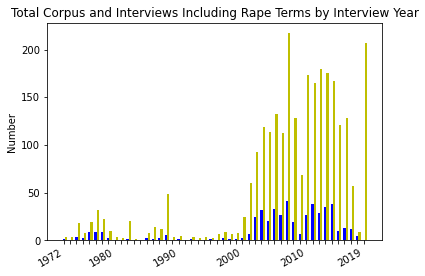

In [36]:
N = 48

ind = np.arange(N) 
values=[]
totals=[]

# some example data

values=hits_formatted
    
    
values = np.array(values)
total=np.array(total)


x = range(len(values))


# and plot it
fig, ax = pyplot.subplots()
hm=ax.bar(ind, values, 0.35, color="b")
total=ax.bar(ind+.35, total, .35, color="y")
ax.set_xticks(ind)
ax.set_xticklabels((1972,"","","","","","","",1980,"","","","","","","","","",1990,"","","","","","","","","",2000,"","","","","","","","","",2010,"","","","","","","","",2019))
ax.set_title('Total Corpus and Interviews Including Rape Terms by Interview Year')
ax.set_ylabel('Number')
pyplot.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')



In [37]:
years=[]
for i in range(1871, 1998):
    years.append(str(i))
years.append("No Info")
total=[]
for i in years:
    total.append(dataformatted["real_interviewee_birth_year"][i])
hits=defaultdict(lambda:0)
print(sum(total))
for x in names:
    id_nums=text_to_ids[x]["id"]
    for num in id_nums:
        hits[ids_to_info[num]["birth_year"]]+=1
hits_formatted=[]
for i in years:
    hits_formatted.append(hits[i])
percentage_withNI=[]
for i in range(len(years)):
    if total[i]==0:
        percentage_withNI.append(0)
    else:    
        percentage_withNI.append(int(hits_formatted[i]/total[i]*100))

2733


In [38]:
df_interview_year = pandas.DataFrame([total, hits_formatted, percentage_withNI], index=["total corpus", "in rape cluster", "Percentage of total"], columns=years)

In [39]:
display(df_interview_year)

,1871,1872,1873,1874,1875,...,1994,1995,1996,1997,No Info
total corpus,1,0,0,1,0,...,1,1,1,1,51
in rape cluster,0,0,0,0,0,...,0,0,0,0,0
Percentage of total,0,0,0,0,0,...,0,0,0,0,0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

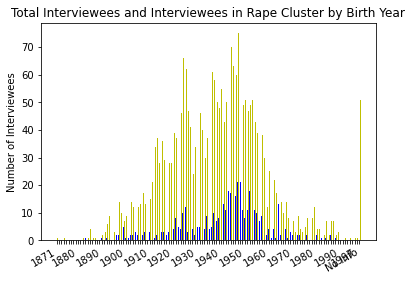

In [40]:
N = 128

ind = np.arange(N) 
values=[]
totals=[]

# some example data

values=hits_formatted
    
    
values = np.array(values)
total=np.array(total)


x = range(len(values))


# and plot it
space=["","","","","","","","",""]
fig, ax = pyplot.subplots()
hm=ax.bar(ind, values, 0.35, color="b")
total=ax.bar(ind+.35, total, .35, color="y")
ax.set_xticks(ind)
ax.set_xticklabels([1871,"","","","","","","","",1880]+space+[1890]+space+[1900]+space+[1910]+space+[1920]+space+[1930]+space+[1940]+space+[1950]+space+[1960]+space+[1970]+space+[1980]+space+[1990, "","","","","","",1997, "No Info"])
ax.set_title('Total Interviewees and Interviewees in Rape Cluster by Birth Year')
ax.set_ylabel('Number of Interviewees')
pyplot.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

By collection breakdowns

In [41]:
collection_database=defaultdict(lambda:0)
for i in range(len(interviewtxt)):
    if interviewtxt["no_transcript"][i]!="TRUE":
        file_name=interviewtxt["project_file_name"][i]
        women=False
        for x in text_to_ids[file_name[:file_name.rfind(".")]]["id"]:
            x=x.strip()
            if database[x]["sex"]=="Female":
                women=True
        if women:
            collection_name=file_name[:file_name.find("_")]
            collection_database[collection_name]+=1
print(collection_database)

defaultdict(<function <lambda> at 0x7fd02babfc10>, {'BWOH': 70, 'BWSP': 162, 'ROHA': 86, 'SCAP': 192, 'SHSA': 30, 'SHSF': 49, 'SNAI': 9, 'RTRB': 137, 'UNCSW': 75, 'UNCGAS': 25, 'UNCTWMS': 145, 'SCAARJ': 14, 'SCAL': 15, 'SCVF': 51, 'OCFF': 20, 'ONA': 47, 'OOHYLC': 67, 'OSS': 150, 'OWDB': 42, 'OWHF': 37, 'SOOH': 174, 'WOL': 46, 'HM': 991})


In [42]:
collections=list(collection_database)
collections.sort()

In [43]:
total=[]
for i in collections:
    total.append(collection_database[i])

In [44]:
pandas.options.display.max_columns = 25

In [45]:
df_collections = pandas.DataFrame([total],columns=collections)

In [46]:
display(df_collections)

,BWOH,BWSP,HM,OCFF,ONA,OOHYLC,OSS,OWDB,OWHF,ROHA,RTRB,SCAARJ,SCAL,SCAP,SCVF,SHSA,SHSF,SNAI,SOOH,UNCGAS,UNCSW,UNCTWMS,WOL
0,70,162,991,20,47,67,150,42,37,86,137,14,15,192,51,30,49,9,174,25,75,145,46


In [47]:
myfile = open("data/everything_but_falsehits_and_needsreview.txt")
txt = myfile.read()
myfile.close()

files=[]
tokens=txt.split()
for i in tokens:
    num= i.find("Files\\\\")
    if not num==-1:
        if not i.find("_")==-1:
            files.append(i.strip())

In [48]:
in_rape_cluster=defaultdict(lambda:0)
found=set()

In [49]:
for i in files:
    if i in found:
        continue
    found.add(i)
    in_rape_cluster[i[7:i.rfind("\\\\")]]+=1

In [50]:
totals=[]
for i in collections:
    totals.append(int(collection_database[i]))
hits=[]
for i in collections:
    hits.append(in_rape_cluster[i])
percentages_in_cluster=[]
percentages_of_total=[]
whole=sum(totals)
percentage_of_hits=[]
number_of_hits=sum(hits)
for i in collections:
    percentages_in_cluster.append(int(100*int(in_rape_cluster[i])/int(collection_database[i])))
    percentages_of_total.append(int(collection_database[i])*100//whole)
    percentage_of_hits.append(int(100*int(in_rape_cluster[i])/number_of_hits))

In [51]:
df_collections = pandas.DataFrame([totals, percentages_of_total, hits, percentages_in_cluster, percentage_of_hits],columns=collections, index=["Number of Interviews", "Percentage of whole corpus",  "Number of Interviews containing rape terms","Percentage of this collection with rape cluster terms","Percent of Interviews including rape terms this collection represents"])

In [52]:
display(df_collections)

,BWOH,BWSP,HM,OCFF,ONA,OOHYLC,OSS,OWDB,OWHF,ROHA,RTRB,SCAARJ,SCAL,SCAP,SCVF,SHSA,SHSF,SNAI,SOOH,UNCGAS,UNCSW,UNCTWMS,WOL
Number of Interviews,70,162,991,20,47,67,150,42,37,86,137,14,15,192,51,30,49,9,174,25,75,145,46
Percentage of whole corpus,2,6,37,0,1,2,5,1,1,3,5,0,0,7,1,1,1,0,6,0,2,5,1
Number of Interviews containing rape terms,23,23,218,0,0,1,2,0,4,12,24,6,7,10,36,3,11,0,3,7,15,64,11
Percentage of this collection with rape cluster terms,32,14,21,0,0,1,1,0,10,13,17,42,46,5,70,10,22,0,1,28,20,44,23
Percent of Interviews including rape terms this collection represents,4,4,45,0,0,0,0,0,0,2,5,1,1,2,7,0,2,0,0,1,3,13,2


In [53]:
print(len(collections))

23


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

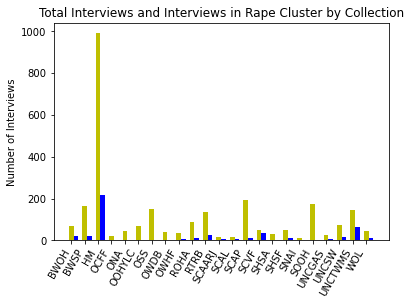

In [54]:
N = 23

ind = np.arange(N) 

# some example data
    
    
values = np.array(hits)
totals=np.array(totals)


x = range(len(values))


# and plot it
fig, ax = pyplot.subplots()
hm=ax.bar(ind, totals, 0.35, color="y")
total=ax.bar(ind+.35, values, .35, color="b")
ax.set_xticks(ind)
ax.set_xticklabels(collections)
ax.set_title('Total Interviews and Interviews in Rape Cluster by Collection')
ax.set_ylabel('Number of Interviews')
pyplot.setp(ax.get_xticklabels(), rotation=60, horizontalalignment='right')

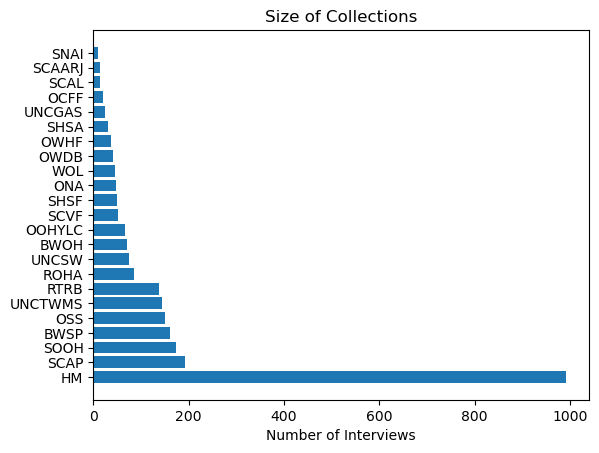

In [55]:
paired=[[collections[i],totals[i]] for i in range(len(collections))]
paired.sort(key=lambda x: x[1])
resorted_coll=[x[0] for x in paired]
resorted_totals=[x[1] for x in paired]

pyplot.rcdefaults()
fig, ax = pyplot.subplots()

# Example data
y_pos = np.arange(len(collections))

ax.barh(y_pos, resorted_totals, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(resorted_coll)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Interviews')
ax.set_title('Size of Collections')

pyplot.show()

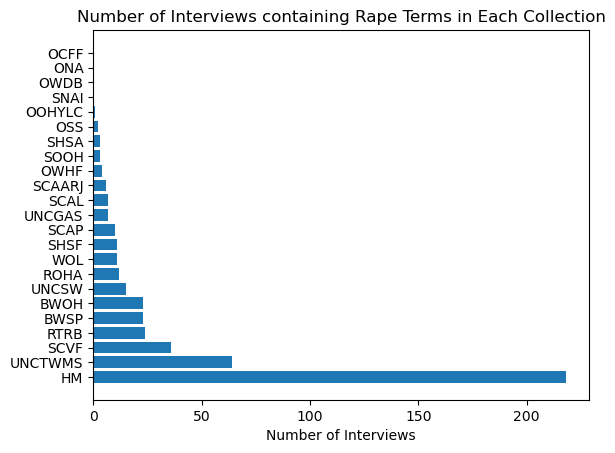

In [56]:
paired=[[collections[i],hits[i]] for i in range(len(collections))]
paired.sort(key=lambda x: x[1])
resorted_coll=[x[0] for x in paired]
resorted_totals=[x[1] for x in paired]

pyplot.rcdefaults()
fig, ax = pyplot.subplots()

# Example data
y_pos = np.arange(len(collections))

ax.barh(y_pos, resorted_totals, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(resorted_coll)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Interviews')
ax.set_title('Number of Interviews containing Rape Terms in Each Collection')

pyplot.show()

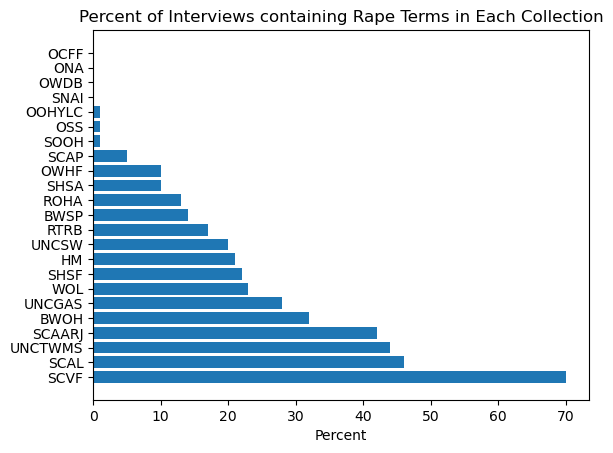

In [57]:
paired=[[collections[i],int(100*hits[i]/totals[i])] for i in range(len(collections))]
paired.sort(key=lambda x: x[1])
resorted_coll=[x[0] for x in paired]
resorted_totals=[x[1] for x in paired]

pyplot.rcdefaults()
fig, ax = pyplot.subplots()

# Example data
y_pos = np.arange(len(collections))

ax.barh(y_pos, resorted_totals, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(resorted_coll)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Percent')
ax.set_title('Percent of Interviews containing Rape Terms in Each Collection')

pyplot.show()

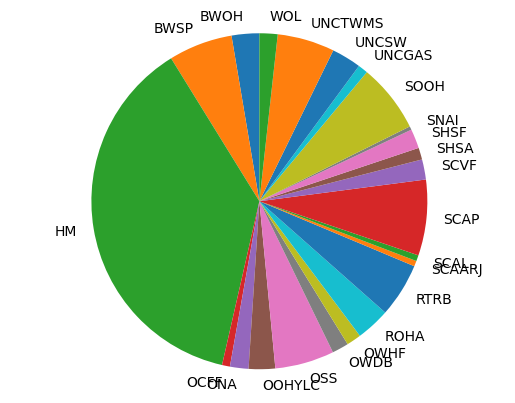

In [58]:

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = collections
sizes = totals
fig1, ax1 = pyplot.subplots()
ax1.pie(sizes, labels=labels, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

pyplot.show()

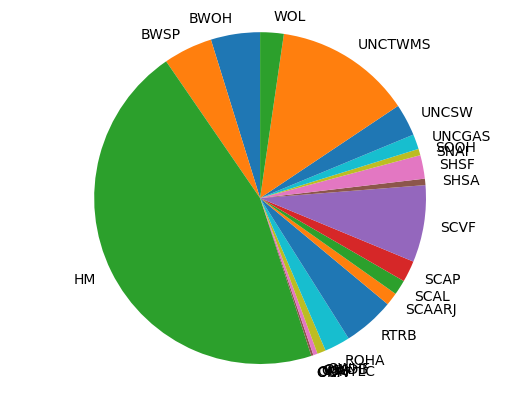

In [59]:
labels = collections
sizes = hits
fig1, ax1 = pyplot.subplots()
ax1.pie(sizes, labels=labels, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

pyplot.show()

In [60]:
new_collections_grouping=defaultdict(lambda:[])
new_collections_grouping["Stanford"]=["SHSA","SHSF","SNAI"]
new_collections_grouping["BWOH"]=["BWOH"]
new_collections_grouping["BWSP"]=["BWSP"]
new_collections_grouping["HM"]=["HM"]
new_collections_grouping["Rutgers"]=["ROHA"]
new_collections_grouping["Smith"]=["SCAP","SCAARJ","SCAL", "SCVF"]
new_collections_grouping["Rosie"]=["RTRB"]
new_collections_grouping["UNC"]=["UNCSW","UNCGAS","UNCTWMS"]
new_collections_grouping["OK"]=["OCFF","OOHYLC","OWHF","WOL","OWDB","SOOH","OSS","ONA"]
groupings_list=["Stanford", "BWOH","Rutgers","Smith","Rosie","UNC","OK","BWSP","HM"]
groupings_list.sort()

In [61]:
totals=[]
for i in groupings_list:
    total_num=0
    for j in new_collections_grouping[i]:
        total_num+=collection_database[j]
    totals.append(total_num)
hits=[]
for i in groupings_list:
    total_num=0
    for j in new_collections_grouping[i]:
        total_num+=in_rape_cluster[j]
    hits.append(total_num)
percentages_in_cluster_grouped=[]
percentages_of_total_grouped=[]
whole=sum(totals)
percentage_of_hits_grouped=[]

for i in range(len(groupings_list)):
    percentages_in_cluster_grouped.append(int(100*int(hits[i])/int(totals[i])))
    percentages_of_total_grouped.append(int(totals[i])*100//whole)
    percentage_of_hits_grouped.append(int(100*int(hits[i])/number_of_hits))

In [62]:
print(groupings_list)
print(totals)
print(hits)
print(percentages_in_cluster_grouped)
print(percentages_of_total_grouped)
print(percentage_of_hits_grouped)

['BWOH', 'BWSP', 'HM', 'OK', 'Rosie', 'Rutgers', 'Smith', 'Stanford', 'UNC']
[70, 162, 991, 583, 137, 86, 272, 88, 245]
[23, 23, 218, 21, 24, 12, 59, 14, 86]
[32, 14, 21, 3, 17, 13, 21, 15, 35]
[2, 6, 37, 22, 5, 3, 10, 3, 9]
[4, 4, 45, 4, 5, 2, 12, 2, 17]


In [63]:
df_collections = pandas.DataFrame([totals, percentages_of_total_grouped, hits, percentages_in_cluster_grouped, percentage_of_hits_grouped],columns=groupings_list, index=["Number of Interviews", "Percentage of whole corpus", "Number of Interviews containing rape terms", "Percentage of this collection containing rape terms","Percent of Interviews including rape terms this collection represents"])

In [64]:
display(df_collections)

,BWOH,BWSP,HM,OK,Rosie,Rutgers,Smith,Stanford,UNC
Number of Interviews,70,162,991,583,137,86,272,88,245
Percentage of whole corpus,2,6,37,22,5,3,10,3,9
Number of Interviews containing rape terms,23,23,218,21,24,12,59,14,86
Percentage of this collection containing rape terms,32,14,21,3,17,13,21,15,35
Percent of Interviews including rape terms this collection represents,4,4,45,4,5,2,12,2,17


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

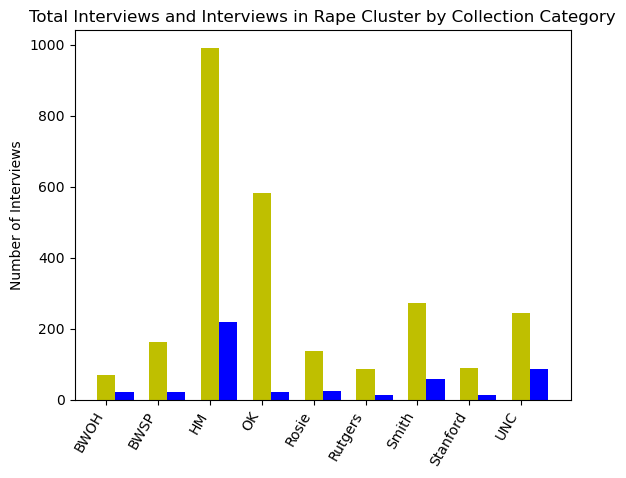

In [65]:
N = 9

ind = np.arange(N) 

# some example data
    
    
values = np.array(hits)
totals=np.array(totals)


x = range(len(values))


# and plot it
fig, ax = pyplot.subplots()
hm=ax.bar(ind, totals, 0.35, color="y")
total=ax.bar(ind+.35, values, .35, color="b")
ax.set_xticks(ind)
ax.set_xticklabels(groupings_list)
ax.set_title('Total Interviews and Interviews in Rape Cluster by Collection Category')
ax.set_ylabel('Number of Interviews')
pyplot.setp(ax.get_xticklabels(), rotation=60, horizontalalignment='right')

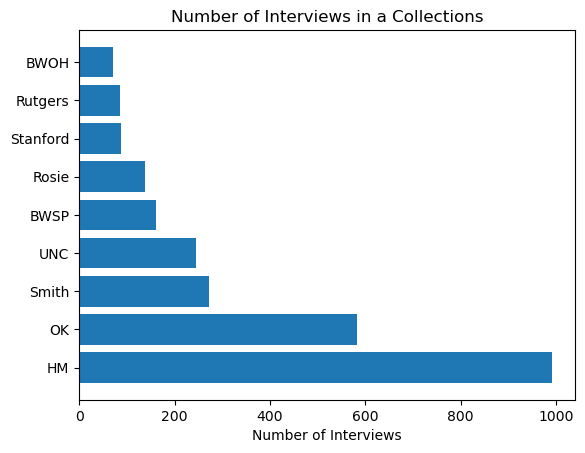

In [66]:
paired=[[groupings_list[i],totals[i]] for i in range(len(groupings_list))]
paired.sort(key=lambda x: x[1])
resorted_coll=[x[0] for x in paired]
resorted_totals=[x[1] for x in paired]

pyplot.rcdefaults()
fig, ax = pyplot.subplots()

# Example data
y_pos = np.arange(len(groupings_list))

ax.barh(y_pos, resorted_totals, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(resorted_coll)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Interviews')
ax.set_title('Number of Interviews in a Collections')

pyplot.show()

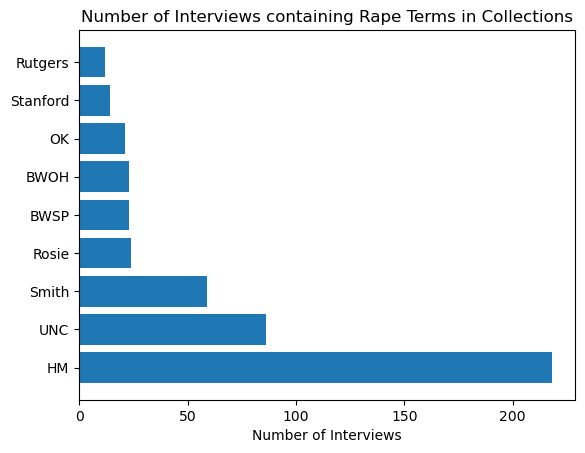

In [67]:
paired=[[groupings_list[i],hits[i]] for i in range(len(groupings_list))]
paired.sort(key=lambda x: x[1])
resorted_coll=[x[0] for x in paired]
resorted_totals=[x[1] for x in paired]

pyplot.rcdefaults()
fig, ax = pyplot.subplots()

# Example data
y_pos = np.arange(len(groupings_list))

ax.barh(y_pos, resorted_totals, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(resorted_coll)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Interviews')
ax.set_title('Number of Interviews containing Rape Terms in Collections')

pyplot.show()

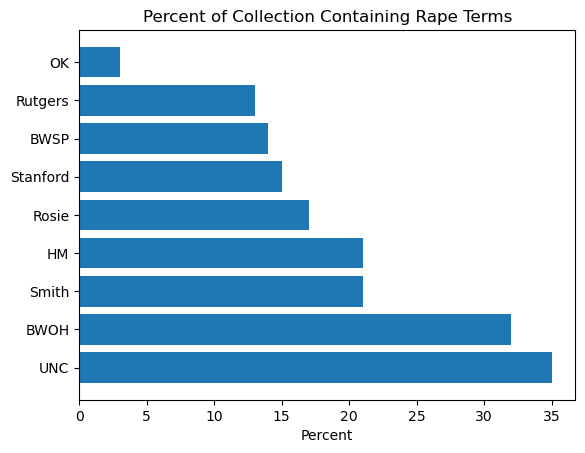

In [68]:
paired=[[groupings_list[i],int(100*hits[i]/totals[i])] for i in range(len(groupings_list))]
paired.sort(key=lambda x: x[1])
resorted_coll=[x[0] for x in paired]
resorted_totals=[x[1] for x in paired]

pyplot.rcdefaults()
fig, ax = pyplot.subplots()

# Example data
y_pos = np.arange(len(groupings_list))

ax.barh(y_pos, resorted_totals, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(resorted_coll)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Percent')
ax.set_title('Percent of Collection Containing Rape Terms')

pyplot.show()

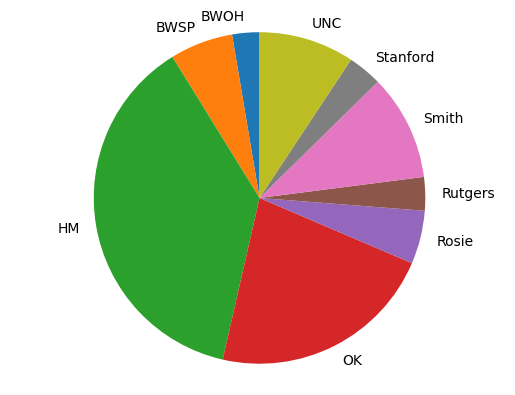

In [69]:

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = groupings_list
sizes = totals
fig1, ax1 = pyplot.subplots()
ax1.pie(sizes, labels=labels, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

pyplot.show()

Total Interviews by Collection Category

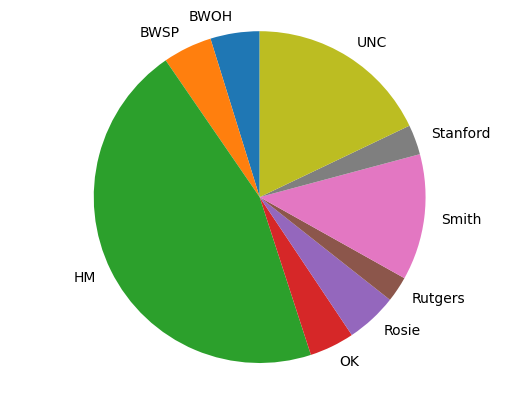

In [70]:
labels = groupings_list
sizes = hits
fig1, ax1 = pyplot.subplots()
ax1.pie(sizes, labels=labels, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

pyplot.show()

Interviews in Rape Cluster by Collection Category

In [71]:
files_formatted=set()
#print(text_to_ids)
for i in files:
    files_formatted.add(i[i.rfind("\\\\")+2:])
print(len(files_formatted))
year_to_number_of_interviews=defaultdict(lambda:0)
year_to_number_of_interviews_CRT=defaultdict(lambda:0)
print(len(text_to_ids))
for i in text_to_ids:
    year_to_number_of_interviews[text_to_ids[i]["interview year"]]+=1
for i in files_formatted:
    year_to_number_of_interviews_CRT[text_to_ids[i[:i.rfind(".")]]["interview year"]]+=1
#print (year_to_number_of_interviews)
#print(year_to_number_of_interviews_CRT)

print("done with first half")

years=[]
for i in range(1972, 2019, 1):
    years.append(str(i))
total=[]
hits_formatted=[]
for i in years:
    total.append(year_to_number_of_interviews[i])
    hits_formatted.append(year_to_number_of_interviews_CRT[i])
print("made the ordered lists")
percentage_withNI=[]
totalnum=sum(total)
print(totalnum)
for i in range(len(years)):
    if total[i]==0:
        percentage_withNI.append(0)
    else:    
        percentage_withNI.append(int(hits_formatted[i]/total[i]*100))


480
4937
done with first half
made the ordered lists
2635


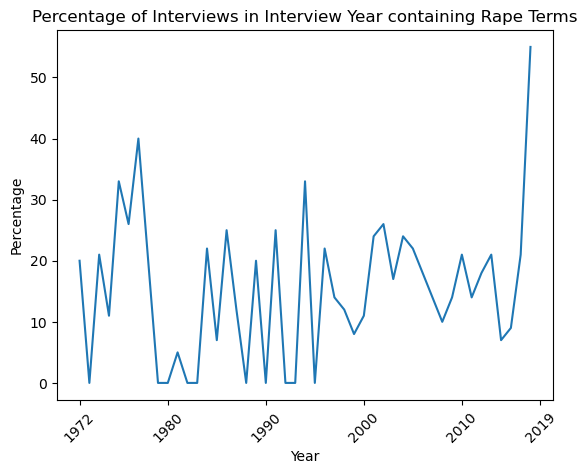

In [72]:
Year = range(47)
percentages = percentage_withNI
if len(percentages)>=48: #number of categories (yes it's janky but it doesn't come up anywhere else right now so I'm leaving it)
    percentages.pop()
pyplot.plot(Year, percentages)
pyplot.title('Percentage of Interviews in Interview Year containing Rape Terms')
pyplot.xlabel('Year')
pyplot.ylabel('Percentage')
pyplot.xticks(rotation = 45)
positions = (0, 9, 19, 29, 39, 47)
labels = (1972, 1980, 1990, 2000, 2010, 2019)
pyplot.xticks(positions, labels)
pyplot.show()

In [73]:
years=[]
for i in range(1971, 2019, 2):
    years.append(i)
total=[]
hits_formatted=[]
for i in years:
    total.append(year_to_number_of_interviews[str(i)]+year_to_number_of_interviews[str(i+1)])
    hits_formatted.append(year_to_number_of_interviews_CRT[str(i)]+year_to_number_of_interviews_CRT[str(i+1)])
percentage_withNI=[]
totalnum=sum(total)
print(totalnum)
for i in range(len(years)):
    if total[i]==0:
        percentage_withNI.append(0)
    else:    
        percentage_withNI.append(int(hits_formatted[i]/total[i]*100))


2635


In [74]:
print(len(percentage_withNI))

24


In [75]:
INCREMENTS=5
years=[]
for i in range(1971, 2019, INCREMENTS):
    years.append(i)
total=[]
hits_formatted=[]
for i in years:
    total_num=0
    hits_num=0
    for j in range(INCREMENTS):
        total_num+=year_to_number_of_interviews[str(i+j)]
        hits_num+= year_to_number_of_interviews_CRT[str(i+j)]
    total.append(total_num)
    hits_formatted.append(hits_num)
percentage_withNI=[]
totalnum=sum(total)
print(totalnum)
for i in range(len(years)):
    if total[i]==0:
        percentage_withNI.append(0)
    else:    
        percentage_withNI.append(int(hits_formatted[i]/total[i]*100))
print(len(percentage_withNI))

2635
10


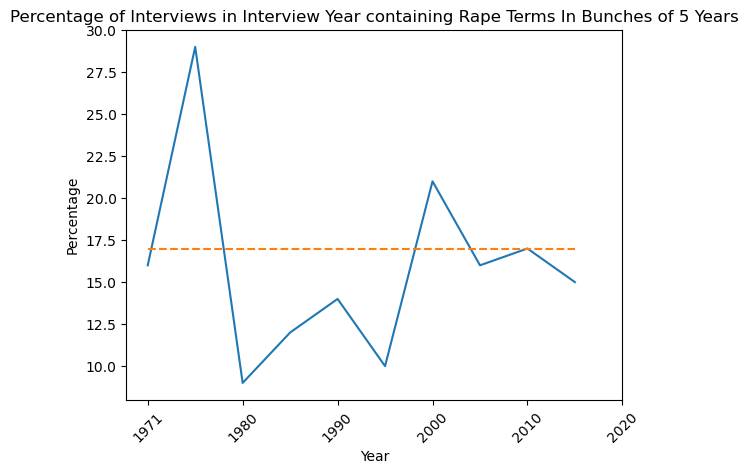

In [76]:
Year = range(len(percentage_withNI))
percentages = percentage_withNI
pyplot.plot(Year, percentages,)
pyplot.plot(Year, [int(100*sum(hits_formatted)/totalnum) for i in range(len(percentage_withNI)) ], linestyle="dashed")
pyplot.title('Percentage of Interviews in Interview Year containing Rape Terms In Bunches of '+str(INCREMENTS)+ " Years")
pyplot.xlabel('Year')
pyplot.ylabel('Percentage')
pyplot.xticks(rotation = 45)
positions = [len(percentage_withNI)*i//5 for i in range(6)]
labels = (1971, 1980, 1990, 2000, 2010, 2020)
pyplot.xticks(positions, labels)
pyplot.show()

In [77]:
INCREMENTS=5
years=[]
for i in range(1971, 2019):
    years.append(i)
total=[]
hits_formatted=[]
for i in years:
    total_num=0
    hits_num=0
    for j in range(max(1971, i-2), min(2019, i+3)):
        total_num+=year_to_number_of_interviews[str(j)]
        hits_num+= year_to_number_of_interviews_CRT[str(j)]
    total.append(total_num)
    hits_formatted.append(hits_num)
percentage_withNI=[]
totalnum=sum(total)
print(totalnum)
for i in range(len(years)):
    if total[i]==0:
        percentage_withNI.append(0)
    else:    
        percentage_withNI.append(int(hits_formatted[i]/total[i]*100))
print(percentage_withNI)
print(total)
print(hits_formatted)

13095
[11, 18, 16, 21, 23, 27, 28, 29, 27, 20, 7, 3, 9, 9, 16, 14, 13, 12, 13, 12, 11, 12, 14, 9, 11, 13, 14, 10, 12, 17, 21, 20, 21, 23, 21, 19, 18, 16, 16, 15, 16, 18, 17, 15, 15, 15, 12, 15]
[9, 32, 49, 73, 102, 120, 107, 94, 73, 59, 38, 28, 33, 44, 36, 85, 90, 86, 72, 64, 17, 16, 14, 21, 26, 30, 34, 55, 108, 196, 310, 417, 530, 584, 710, 717, 671, 715, 781, 752, 805, 911, 861, 813, 676, 504, 329, 198]
[1, 6, 8, 16, 24, 33, 30, 28, 20, 12, 3, 1, 3, 4, 6, 12, 12, 11, 10, 8, 2, 2, 2, 2, 3, 4, 5, 6, 13, 35, 66, 85, 116, 135, 152, 139, 126, 120, 132, 120, 135, 166, 149, 124, 107, 78, 40, 30]


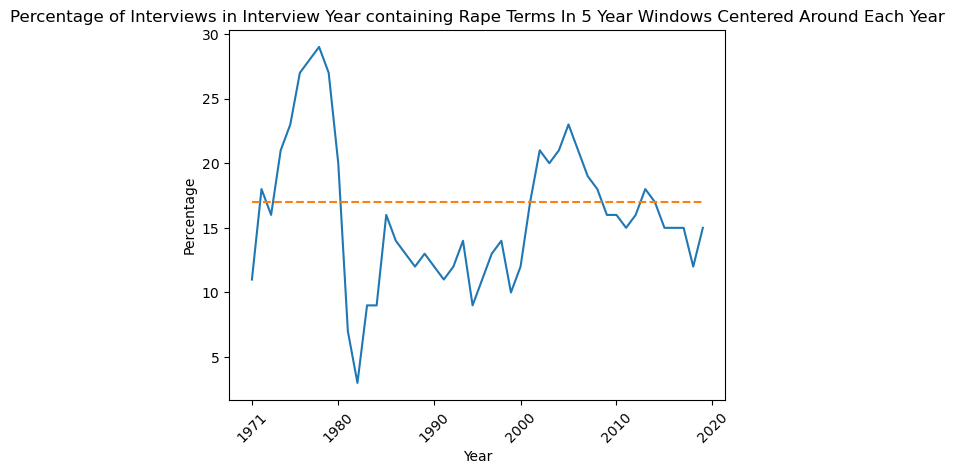

In [78]:
Year = range(len(percentage_withNI))
percentages = percentage_withNI
pyplot.plot(Year, percentages)
pyplot.plot(Year, [int(100*sum(hits_formatted)/totalnum) for i in range(len(percentage_withNI)) ], linestyle="dashed")
pyplot.title('Percentage of Interviews in Interview Year containing Rape Terms In '+str(INCREMENTS)+ " Year Windows Centered Around Each Year")
pyplot.xlabel('Year')
pyplot.ylabel('Percentage')
pyplot.xticks(rotation = 45)
positions = [len(percentage_withNI)*i//5 for i in range(6)]
labels = (1971, 1980, 1990, 2000, 2010, 2020)
pyplot.xticks(positions, labels)
pyplot.show()

In [94]:
files_formatted=set()
#print(database)
for i in files:
    files_formatted.add(i[i.rfind("\\\\")+2:])
print(len(files_formatted))
year_to_number_of_interviews_white=defaultdict(lambda:0)
year_to_number_of_interviews_CRT_white=defaultdict(lambda:0)
year_to_number_of_interviews_black=defaultdict(lambda:0)
year_to_number_of_interviews_CRT_black=defaultdict(lambda:0)
print(len(text_to_ids))
for i in text_to_ids:
    if database[text_to_ids[i]["id"][0]]["identified_race"]=="White":
        year_to_number_of_interviews_white[text_to_ids[i]["interview year"]]+=1
    elif database[text_to_ids[i]["id"][0]]["identified_race"]=="Black or African American":
        year_to_number_of_interviews_black[text_to_ids[i]["interview year"]]+=1
print(year_to_number_of_interviews_white)
for i in files_formatted:
    key=text_to_ids[i[:i.rfind(",")]]["id"][0]
    if database[key]["identified_race"]=="White":
        year_to_number_of_interviews_CRT_white[text_to_ids[i[:i.rfind(",")]]["interview year"]]+=1
    elif database[key]["identified_race"]=="Black or African American":
        year_to_number_of_interviews_CRT_black[text_to_ids[i[:i.rfind(",")]]["interview year"]]+=1


years=[]
for i in range(1972, 2019, 1):
    years.append(str(i))
total_white=[]
hits_formatted_white=[]
total_black=[]
hits_formatted_black=[]
for i in years:
    total_white.append(year_to_number_of_interviews_white[str(i)])
    hits_formatted_white.append(year_to_number_of_interviews_CRT_white[str(i)])
    total_black.append(year_to_number_of_interviews_black[str(i)])
    hits_formatted_black.append(year_to_number_of_interviews_CRT_black[str(i)])
print(hits_formatted_white)
percentage_withNI_white=[]
percentage_withNI_black=[]
totalnum=sum(total)
print(totalnum)
for i in range(len(years)):
    if total_white[i]==0:
        percentage_withNI_white.append(0)
    else:    
        percentage_withNI_white.append(int(hits_formatted_white[i]/total_white[i]*100))
    if total_black[i]==0:
        percentage_withNI_black.append(0)
    else:
        percentage_withNI_black.append(int(hits_formatted_black[i]/total_black[i]*100))
print(percentage_withNI_white)


480
5419
defaultdict(<function <lambda> at 0x7fd02b9bcf70>, {'1987': 10, '1982': 20, '1988': 47, '2013': 70, '1986': 14, '1972': 5, '1981': 3, '1990': 5, '1983': 1, '1985': 8, '2017': 19, '2018': 7, '1992': 4, '1989': 3, '2005': 20, '2014': 91, 'RBNF2': 7, '2010': 128, '2016': 66, '1996': 6, '2015': 89, '2012': 92, '2006': 16, '1998': 7, '1997': 8, '1999': 8, '2007': 84, '2009': 58, '2008': 57, '2003': 14, '2000': 8, '2001': 37, '2011': 128, '1994': 1, 'July, 1977': 1, '1979': 1, '2002': 9, '2004': 11, '1976': 14, '1975': 17, '1974': 19, '1973': 4, '1977': 2, '1964': 1, '1980': 1, '1978': 2, '1976-04': 1})
[1, 0, 3, 2, 3, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 2, 5, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 3, 6, 7, 4, 17, 11, 5, 13, 28, 10, 11, 13, 7, 7, 2, 5]
13095
[20, 0, 15, 11, 21, 50, 0, 0, 0, 0, 5, 0, 0, 12, 7, 20, 10, 0, 20, 0, 25, 0, 0, 0, 0, 12, 14, 12, 0, 2, 11, 21, 54, 35, 25, 20, 19, 8, 10, 21, 10, 15, 14, 7, 10, 10, 71]


In [115]:
years=[]
for i in range(1971, 2019):
    years.append(i)
total_white=[]
hits_formatted_white=[]
total_black=[]
hits_formatted_black=[]
for i in years:
    total_num_white=0
    hits_num_white=0
    total_num_black=0
    hits_num_black=0
    for j in range(max(1971, i-2), min(2019, i+3)):
        total_num_white+=year_to_number_of_interviews_white[str(j)]
        hits_num_white+= year_to_number_of_interviews_CRT_white[str(j)]
        total_num_black+=year_to_number_of_interviews_black[str(j)]
        hits_num_black+= year_to_number_of_interviews_CRT_black[str(j)]
    total_black.append(total_num_black)
    hits_formatted_black.append(hits_num_black)
    total_white.append(total_num_white)
    hits_formatted_white.append(hits_num_white)
percentage_withNI_white=[]
percentage_withNI_black=[]
totalnum=sum(total)
print(totalnum)
for i in range(len(years)):
    if total_black[i]==0:
        percentage_withNI_black.append(0)
    else:    
        percentage_withNI_black.append(int(hits_formatted_black[i]/total_black[i]*100))
    if total_white[i]==0:
        percentage_withNI_white.append(0)
    else:    
        percentage_withNI_white.append(int(hits_formatted_white[i]/total_white[i]*100))
print(percentage_withNI_black)
print(total_black)
print(hits_formatted_black)

13095
[0, 50, 50, 50, 32, 36, 33, 32, 29, 34, 16, 0, 100, 100, 100, 66, 66, 50, 50, 0, 0, 0, 11, 10, 18, 25, 40, 16, 23, 25, 25, 21, 21, 21, 19, 17, 18, 19, 19, 22, 24, 27, 25, 23, 22, 23, 14, 14]
[0, 4, 4, 14, 46, 66, 71, 74, 64, 32, 12, 3, 1, 1, 2, 3, 3, 2, 2, 1, 3, 6, 9, 10, 11, 8, 5, 18, 39, 124, 226, 327, 414, 485, 533, 497, 404, 344, 271, 217, 233, 292, 264, 287, 234, 152, 85, 70]
[0, 2, 2, 7, 15, 24, 24, 24, 19, 11, 2, 0, 1, 1, 2, 2, 2, 1, 1, 0, 0, 0, 1, 1, 2, 2, 2, 3, 9, 31, 57, 70, 89, 105, 105, 86, 75, 68, 52, 48, 58, 80, 68, 67, 53, 36, 12, 10]


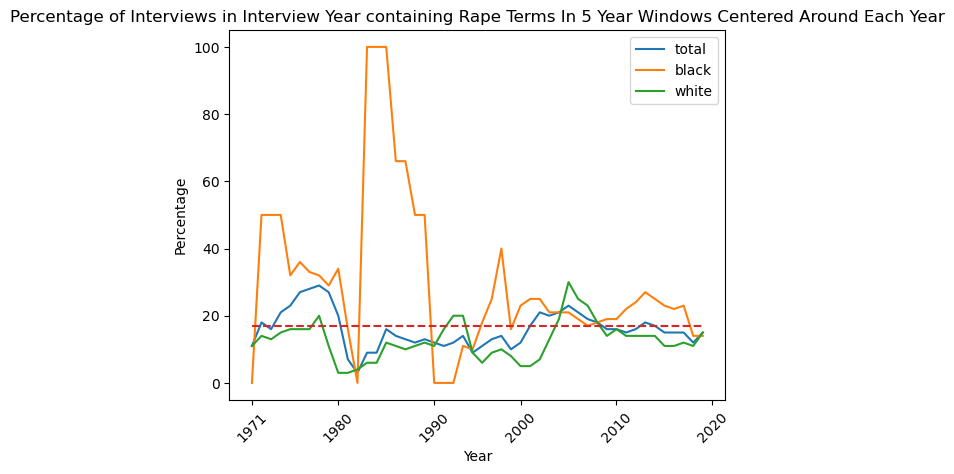

In [116]:
Year = range(len(percentage_withNI_white))
percentages = percentage_withNI_white
pyplot.plot( Year, percentage_withNI, label="total")
pyplot.plot( Year, percentage_withNI_black, label="black")
pyplot.plot( Year, percentage_withNI_white, label="white")
pyplot.plot(Year, [int(100*sum(hits_formatted)/totalnum) for i in range(len(percentage_withNI)) ], linestyle="dashed")
pyplot.title('Percentage of Interviews in Interview Year containing Rape Terms In '+str(INCREMENTS)+ " Year Windows Centered Around Each Year")
pyplot.xlabel('Year')
pyplot.ylabel('Percentage')
pyplot.xticks(rotation = 45)
positions = [len(percentage_withNI)*i//5 for i in range(6)]
labels = (1971, 1980, 1990, 2000, 2010, 2020)
pyplot.xticks(positions, labels)
pyplot.legend()
pyplot.show()